In [2]:
%load_ext autoreload
%autoreload 2
from course_helpers import *
from helpers import *
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
from torch.nn import Sequential, Module, LSTM, ReLU, Linear, Sigmoid, Dropout, Embedding
import torchvision
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataloader import default_collate
from datetime import datetime
import torch.nn.functional as F
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

##data preprocessing 
DATA_PATH = 'twitter-datasets'
Dataset = read(DATA_PATH)

#@title read dataset file


/root/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['train_neg.txt', 'train_pos.txt', 'sample_submission.csv', 'test_data.txt', 'train_neg_clean.txt', 'train_pos_clean.txt', 'test_data_clean.txt']


In [4]:
# Dataset = clean(Dataset)
# save_to_file(Dataset)

In [5]:
!bash course_helpers.sh
##Run this in terminal

In [6]:
vocab_cut = 'vocab_cut.txt'
vocab_pkl = 'vocab_pkl.pkl'
coco_pkl = 'coco_pkl.pkl'
embd = 'embeddings'

In [7]:
# pickle_vocab(vocab_cut, vocab_pkl)
# cooc_(vocab_pkl, DATA_PATH, coco_pkl)
# glove(coco_pkl, embd)
# with open(coco_pkl, "rb") as f:
#         cooc = pickle.load(f)
# print(cooc.shape)
# with open(vocab_pkl, "rb") as f:
#         vocab = pickle.load(f)
# print(len(vocab))

In [4]:

embedding = np.load(embd+'.npy')
print(embedding.shape)
glove_embd = embedding

(17971, 20)


In [9]:
# train_pos, train_neg, test_set = read_data(Dataset)
# train_set = pd.concat([train_pos, train_neg],  axis=0, ignore_index=True)
# train_set = pd.concat([train_set.drop(labels='sentiment', axis=1), train_set['sentiment']], axis = 1)

# train_set.loc[:, train_set.columns!='sentiment'] = train_set.applymap(lambda x: find_token(x, vocab))
# test_set2 =  test_set.applymap(lambda x: find_token(x, vocab))
# train_set.to_csv('train_set_token.csv', index= False)
# test_set2.to_csv('test_set_token.csv', index= False)

In [5]:
test_set = pd.read_csv('test_set_token.csv')
train_set = pd.read_csv('train_set_token.csv', )
num_embeddings  = glove_embd.shape[0]
embed_dim = glove_embd.shape[1]
max_len = train_set.shape[1]-1
batch_size = 16
n_batches = train_set.shape[0]/batch_size

X_train = train_set.loc[:, train_set.columns!='sentiment']
Y_train = train_set['sentiment']
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
glove_embd = torch.tensor(glove_embd)

In [7]:
train_set

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,sentiment
0,0,2,33,5,16,56,562,429,15,1077,...,5,5,5,5,5,5,5,5,5,1
1,177,42,2692,14,27,1603,6,2,5,38,...,5,5,5,5,5,5,5,5,5,1
2,25,0,40,323,10153,22,10,722,3,25,...,5,5,5,5,5,5,5,5,5,1
3,0,0,88,1525,125,125,33,16,811,574,...,5,5,5,5,5,5,5,5,5,1
4,3977,15,481,1928,14,5,4212,188,1083,5,...,5,5,5,5,5,5,5,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179482,87,16,162,7,1336,1288,164,3,168,201,...,5,5,5,5,5,5,5,5,5,0
179483,0,2921,2,424,15,1033,2967,1,9,5,...,5,5,5,5,5,5,5,5,5,0
179484,5,9555,1688,5,4,5,352,948,5,4,...,5,5,5,5,5,5,5,5,5,0
179485,5,14,172,59,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,0


In [43]:
histogram = X_train
histogram['num_uniq'] = histogram.apply(pd.Series.nunique, axis=1)
histogram = histogram['num_uniq']
histogram

0         28
1         21
2         12
3         19
4         12
          ..
179482    13
179483    32
179484    18
179485     5
179486    10
Name: num_uniq, Length: 179487, dtype: int64

In [46]:
# Need not be sorted, necessarily
a = (0, 1, 1, 1, 2, 3, 7, 7, 23)

def count_elements(seq) -> dict:
    """Tally elements from `seq`."""
    hist = {}
    for i in seq:
        hist[i] = hist.get(i, 0) + 1
    return hist
counted =count_elements(histogram)


In [73]:
histogram.shape

(179487,)

<BarContainer object of 144 artists>

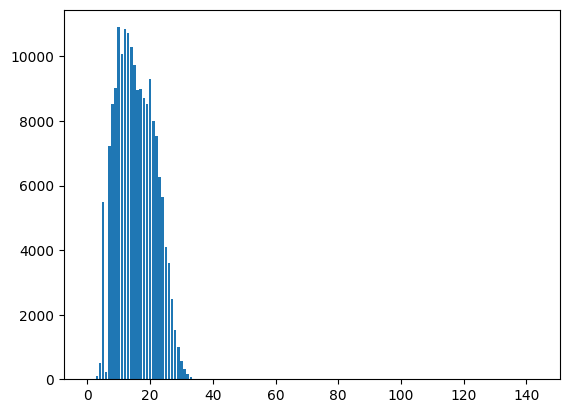

In [74]:
import matplotlib.pyplot as plt
hist,bins = np.histogram(histogram,bins = [i for i in range(0, 145, 1)]) 
plt.bar(bins[:-1], hist)

In [27]:
data_split = (X_train.shape[0]*0.2)%batch_size
data_split  = X_train.shape[0]*0.2 - data_split
data_split=data_split/2
remd = -data_split + X_train.shape[0] - data_split
addedv = remd%data_split


In [28]:
X_val =  torch.tensor(pd.concat([X_train[:int(data_split)], X_train[-int(data_split):]],  axis=0, ignore_index=True).reset_index(drop=True).to_numpy()).to(device)
Y_val =  torch.tensor(pd.concat([Y_train[:int(data_split)], Y_train[-int(data_split):]],  axis=0, ignore_index=True).reset_index(drop=True).to_numpy(dtype='float32')).to(device)
X_train = torch.tensor(X_train[int(data_split+addedv):-int(data_split)].reset_index(drop=True).to_numpy()).to(device)
Y_train =  torch.tensor(Y_train[int(data_split+addedv):-int(data_split)].reset_index(drop=True).to_numpy(dtype='float32')).to(device)

In [29]:
X_test =  torch.tensor(test_set.to_numpy()).to(device)


In [30]:
class make_torch_dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=[]):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        inp = self.encodings[idx]
        label = self.labels[idx]
        return inp, label

    def __len__(self):
        return len(self.encodings)

class make_torch_testset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        inp = self.encodings[idx]
        return inp

    def __len__(self):
        return len(self.encodings)

train_dataset = make_torch_dataset(X_train, Y_train)
val_dataset = make_torch_dataset(X_val, Y_val)
test_dataset = make_torch_testset(X_test)

In [31]:
# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Report split sizes
print('Training set has {} instances'.format(len(train_dataset)))
print('Validation set has {} instances'.format(len(val_dataset)))
print('Test set has {} instances'.format(len(test_dataset)))

Training set has 143552 instances
Validation set has 35888 instances
Test set has 10000 instances


In [32]:

class lstm_classifier(Module):
    def __init__(self, num_embeddings, embed_dim, glove_embd, max_len) -> None:
        super().__init__()
        self.emd =  Embedding(num_embeddings= num_embeddings, embedding_dim= embed_dim, _weight=glove_embd)
        self.lstm1 = LSTM(input_size = embed_dim, hidden_size = 256, bidirectional = True, batch_first  = True)
        self.lstm2 = LSTM(input_size = 512, hidden_size = 150, bidirectional = True,  batch_first  = True)
        self.fc1 = Linear(300,128)
        self.drp = Dropout(0.1)
        self.fc2 = Linear(128, 64)
        self.fc3 = Linear(64,1)
        self.reg = Sigmoid()


    def forward(self, x):
        x = self.emd(x)
        x = x.to(torch.float32)
        x, states = self.lstm1(x)
        x, states = self.lstm2(x)
        x = F.relu(self.fc1(x[:,0]))
        x = self.drp(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.reg(x)
        x = x.reshape(x.shape[0])

        return x
model = lstm_classifier(num_embeddings, embed_dim, glove_embd, max_len).to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    running_accuracy = 0.0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting

    with tqdm(training_loader, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch_index}")


    #for i, data in enumerate(tqdm(training_loader), unit= "batches", ):
            # Every data instance is an input + label pair
            inputs, labels = data

            # Zero your gradients for every batch!
            optimizer.zero_grad()


            # Make predictions for this batch
            outputs = model(inputs)
            accuracy  = accuracy_score(labels.cpu(), [1 if x > 0.5 else 0 for x in outputs.cpu()])
            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            # Gather data and report
            running_loss += loss.item()
            running_accuracy += accuracy

            tepoch.set_postfix(loss=loss.item(), accuracy = accuracy)
            if i % batch_size == batch_size-1:
                last_loss = running_loss / batch_size # loss per batch
                #print('  epoch {} batch {} loss: {}'.format(epoch_index, (i + 1)/batch_size, last_loss))
                tb_x = epoch_index * len(training_loader) + i + 1
                #print(tb_x)
                tb_writer.add_scalar('Loss/train', last_loss, global_step = tb_x)
                running_loss = 0.

    return last_loss, running_accuracy/i

In [18]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.



for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, acc = train_one_epoch(epoch, writer)

    # # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    running_vacc = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs).detach()
        vacc  = accuracy_score(vlabels.cpu(), [1 if x > 0.5 else 0 for x in voutputs.cpu()])
        running_vacc += vacc
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    avg_vacc = running_vacc / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch + 1)
    writer.add_scalars('Training vs. Validation Accuracy',
                    { 'Training' : acc, 'Validation' : avg_vacc },
                    epoch + 1)
    #writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch)
        torch.save(model.state_dict(), model_path)


EPOCH 1:


Epoch 0:   0%|          | 0/8972 [00:00<?, ?batch/s]

0.5625


Epoch 0:   0%|          | 1/8972 [00:00<1:51:06,  1.35batch/s, accuracy=0.562, loss=0.691]

0.5625
0.375


Epoch 0:   0%|          | 2/8972 [00:01<2:07:56,  1.17batch/s, accuracy=0.375, loss=0.702]

0.9375
0.5625


Epoch 0:   0%|          | 4/8972 [00:02<1:20:34,  1.86batch/s, accuracy=0.375, loss=0.698]

1.5
0.375
1.875
0.25


Epoch 0:   0%|          | 4/8972 [00:02<1:20:34,  1.86batch/s, accuracy=0.25, loss=0.701] 

2.125
0.4375


Epoch 0:   0%|          | 6/8972 [00:03<59:52,  2.50batch/s, accuracy=0.438, loss=0.694]  

2.5625
0.375


Epoch 0:   0%|          | 7/8972 [00:04<1:22:05,  1.82batch/s, accuracy=0.375, loss=0.695]

2.9375
0.375


Epoch 0:   0%|          | 8/8972 [00:05<1:48:37,  1.38batch/s, accuracy=0.375, loss=0.694]

3.3125
0.4375


Epoch 0:   0%|          | 9/8972 [00:06<1:53:59,  1.31batch/s, accuracy=0.438, loss=0.693]

3.75
0.5


Epoch 0:   0%|          | 10/8972 [00:07<2:01:17,  1.23batch/s, accuracy=0.5, loss=0.693] 

4.25
0.5625


Epoch 0:   0%|          | 11/8972 [00:07<2:06:36,  1.18batch/s, accuracy=0.562, loss=0.693]

4.8125
0.5625


Epoch 0:   0%|          | 11/8972 [00:08<1:56:25,  1.28batch/s, accuracy=0.562, loss=0.693]


KeyboardInterrupt: 

In [86]:
model.train(False)
preds_test = []
for i, vdata in enumerate(test_loader):
    vinputs = vdata
    voutputs = model(vinputs).detach()
    preds_test.extend(voutputs.cpu())



In [93]:
preds = np.ones_like(preds_test)
preds[np.where(np.array(preds_test)<0.5)] = -1
preds = pd.DataFrame(preds)

-10000.0


In [99]:
import csv
def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in .csv format for submission to Kaggle or AIcrowd
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, "w") as csvfile:
        fieldnames = ["Id", "Prediction"]
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({"Id": int(r1)+1, "Prediction": int(r2)})

create_csv_submission(preds.index.values.tolist(), np.asarray(preds), "____test____.csv")

# old stuff

In [10]:
%load_ext autoreload
%autoreload 2
from course_helpers import *
from helpers import *



##data preprocessing 
DATA_PATH = 'twitter-datasets'
Dataset = read(DATA_PATH)

#@title read dataset file
vocab_cut = 'vocab_cut.txt'
vocab_pkl = 'vocab_pkl.pkl'
coco_pkl = 'coco_pkl.pkl'
embd = 'embeddings'
with open(coco_pkl, "rb") as f:
        cooc = pickle.load(f)
print(cooc.shape)
with open(vocab_pkl, "rb") as f:
        vocab = pickle.load(f)
print(len(vocab))
embedding = np.load(embd+'.npy')
print(embedding.shape)
glove_embd = embedding

test_set = pd.read_csv('test_set_token.csv')
train_set = pd.read_csv('train_set_token.csv')

num_embeddings  = glove_embd.shape[0]
embed_dim = glove_embd.shape[1]
max_len = train_set.shape[1]-1

import torch
from torch.nn import Sequential, Module, LSTM, ReLU, Linear, Sigmoid, Dropout, Embedding
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
glove_embd = torch.tensor(glove_embd)
training = torch.tensor(train_set.values)

net = Sequential(
      Embedding(num_embeddings= num_embeddings, embedding_dim= embed_dim, _weight=glove_embd),
      LSTM(input_size = embed_dim, hidden_size = 256, bidirectional = True),
      LSTM(input_size = 256, hidden_size = 150, bidirectional = True),
      Linear(150,128),
      ReLU(),
      Dropout(0.1),
      Linear(128, 64),
      ReLU(),
      Linear(64,1),
      Sigmoid()
      )
net.forward(training[:5])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['train_neg.txt', 'train_pos.txt', 'sample_submission.csv', 'test_data.txt', 'train_neg_clean.txt', 'train_pos_clean.txt', 'test_data_clean.txt']
(17971, 17971)
17971
(17971, 20)
